7-ExamplePythonAPI_MiniAPTERROS_Propellers.ipynb
    v1  2022-03-18  SV

# Use of Python API to control the MiniAPTERROS vehicule (actuators and propellers)

This notebook imports 2 modules from the directory `coppeliasim/env` :
- sim.py
- simConst.py 

It also needs the appropriate remote API library: "remoteApi.dll" (Windows), "remoteApi.dylib" (Mac) or "remoteApi.so" (Linux)

The CoppeliaSim Python API is documented here: http://www.coppeliarobotics.com/helpFiles/en/remoteApiFunctionsPython.htm

The cell bellow finds the relative path of the directory `coppeliasim_api/env` where the modules `sim` and `simConst` live:<br>
if not found in the current working dir it tries recursively to find a parent directory that holds `coppeliasim/env`.<br>
When found, it sets `root_dir` to this value and adds relevant paths to the list sys.path:

In [1]:
import sys, os

# initialize default path values:
target_dir = "coppeliasim_api/env"
root_dir = os.getcwd()
copsim_env_path = target_dir

if not os.path.isdir(target_dir):
    while not os.path.isdir(copsim_env_path):
        copsim_env_path = os.path.join('..', copsim_env_path)
    root_dir = copsim_env_path.replace(target_dir, "")

# run notebook in root dir and add the required paths to sys.path:
if  root_dir !=  os.getcwd():  
    os.chdir(root_dir)
    sys.path.append(root_dir)
    sys.path.append(target_dir)

print(f"\troot directory: <{root_dir}>")
print(f"\tworking directory is now: <{os.getcwd()}>")

# automatic reload of modules when modification
%load_ext autoreload
%autoreload 2

	root directory: <../../>
	working directory is now: </home/jlc/work/ENSAM/Projets/Mini-Apterros/gitlab.com/miniapterros>


In [2]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported.')
    print ('--------------------------------------------------------------')
    print ('')
    raise

import time, sys
import numpy as np
from CopSim import Simulator

error_mess = 'Remote API error code: '
OK = sim.simx_return_ok

opmode_blocking    = sim.simx_opmode_blocking
opmode_oneshot     = sim.simx_opmode_oneshot
opmode_buffer      = sim.simx_opmode_buffer
opmode_streaming   = sim.simx_opmode_streaming
opmode_discontinue = sim.simx_opmode_discontinue

np.set_printoptions(precision=3)

## >>> Automatic launch of a CoppeliaSim instance:

**Only for Linux & MacOS** !!! <br>
=> Windows : 
- run CoppeliaSim "by hand" 
- go to the next cell "Connection to the CoppeliaSim simulator...

The file `constants.py` in `coppeliasim_api/env` sets COPSIM_DIR & COPSIM_APP_MacOS to the name of the CoppeliaSim installation directory... modify it as needed.

In [3]:
import platform
if platform.system() =='Linux':
    # LINUX CUSTOMIZE : the file 'constants.py' from 'coppeliasim_api/env' sets COPSIM_DIR 
    # to the name of the CoppeliaSim installation directory : modify it as needed...
    from constants import COPSIM_DIR
    print(f"CoppeliaSim installation found in directory <{COPSIM_DIR}>")
    simulator = Simulator(19997, COPSIM_DIR, headless=False, verbose=1)
    simulator.start()

elif platform.system() =='Darwin':
    # MacOS CUSTOMIZE : the file 'constants.py' from 'coppeliasim_api/env' sets COPSIM_APP_MacOS
    # to the name of the CoppeliaSim installation file (.app) : modify it as needed...
    import os
    from constants import COPSIM_APP_MacOS
    print(COPSIM_APP_MacOS)
    os.system("open "+ COPSIM_APP_MacOS)
else:
    print("""Only for Linux & MacOS platforms !!!
Windows : run CoppeliaSim "by hand" and go to the cell "Connection to the CoppeliaSim simulator...""")    

CoppeliaSim installation found in directory <CoppeliaSim_Edu_V4_3_0_Ubuntu20_04>
[CopSim] starting an instance of CoppeliaSim...
[Instance] trying to start <./coppeliaSim.sh -gREMOTEAPISERVERSERVICE_19997_FALSE_TRUE -vnone>
[CopSim] CoppeliaSim instance started, remote API connection OK.


## Connection to the CoppeliaSim simulator:

In [4]:
sim.simxFinish(-1) # just in case, close all opened connections

clientID = sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP

if clientID == -1:
    print ('NOT Connected to remote API server')
    sys.exit("Could not connect")
else:
    print ('Successfully connected to the remote CoppeliaSim server with clientID={}'.format(clientID))

Successfully connected to the remote CoppeliaSim server with clientID=0


### Load the Scene

In [5]:
scene = "./vehicule/copsim/Mini-APTERROS_v5.3.ttt"
res = sim.simxLoadScene(clientID, scene, 0xFF, opmode_blocking)
if res == OK:
    print ('Scene <{}> successfully loaded !'.format(scene))
else:
    print (error_mess, res)

Scene <./vehicule/copsim/Mini-APTERROS_v5.3.ttt> successfully loaded !


### Get the handles for the 2 actuators ("vérins électriques") and 4 propellers ("turbines électriques")

In [6]:
res, actuator1 = sim.simxGetObjectHandle(clientID, "actuator1", opmode_blocking)
res, actuator2 = sim.simxGetObjectHandle(clientID, "actuator2", opmode_blocking)
res, propPlate = sim.simxGetObjectHandle(clientID, "propellersPlate", opmode_blocking)
print (f'Handles:\n\t actuator1: {actuator1}, actuator2: {actuator2}, propellersPlate: {propPlate}')
  
res, propeller1 = sim.simxGetObjectHandle(clientID, "propeller1", opmode_blocking)
res, propeller2 = sim.simxGetObjectHandle(clientID, "propeller2", opmode_blocking)
res, propeller3 = sim.simxGetObjectHandle(clientID, "propeller3", opmode_blocking)
res, propeller4 = sim.simxGetObjectHandle(clientID, "propeller4", opmode_blocking)
print (f'Handles:\n\t propeller1: {propeller1}, propeller2: {propeller2}, propeller3: {propeller3}, propeller4: {propeller4}')

Handles:
	 actuator1: 48, actuator2: 60, propellersPlate: 16
Handles:
	 propeller1: 17, propeller2: 22, propeller3: 27, propeller4: 32


## Physical simulation with actuators blocked and a set propeller speed

Actuators are `motor_enabled` checked but `Control loop enabled` **unchecked**.

dt is set to 10ms in CoppeliaSIm

In [21]:
# Request for synchronous operation:
sim.simxSynchronous(clientID,True)

# set the timestep simulation : the CoppeliaSim scene must be configured with 'dt=50.0 ms (custom)'
dt = 100.e-3 # ms
sim.simxSetFloatingParameter(clientID, sim.sim_floatparam_simulation_time_step, dt, opmode_blocking)
res = sim.simxSynchronous(clientID, True); assert res == 0

timeSimu, propPlate_z = 0, 0
M, P_speed, T_force = [], [], []

particle_speed = 45

res = sim.simxStartSimulation(clientID, opmode_blocking); assert res == 0
res = sim.simxSynchronousTrigger(clientID); assert res == OK

inputs = [[], [particle_speed], [], bytearray()]
for prop_id in ('propeller1', 'propeller3', 'propeller4', 'propeller2'):
    res = sim.simxCallScriptFunction(clientID, prop_id, sim.sim_scripttype_childscript, 'setPropellerParams', *inputs, opmode_blocking)
    assert res[0] == OK
    
#Change the desired stop altitude here (in meters)
while propPlate_z <= 1:
    res = sim.simxSynchronousTrigger(clientID); assert res == OK
    timeSimu = sim.simxGetLastCmdTime(clientID)

    res, pos1 = sim.simxGetJointPosition(clientID, actuator1, opmode_blocking); assert res == OK
    res, pos2 = sim.simxGetJointPosition(clientID, actuator2, opmode_blocking); assert res == OK
    res, (propPlate_x, propPlate_y, propPlate_z) = sim.simxGetObjectPosition(clientID, propPlate, -1, opmode_blocking); assert res == OK
    
    res = sim.simxSetJointPosition(clientID, actuator1, 0, opmode_blocking); assert res == OK
    res = sim.simxSetJointPosition(clientID, actuator2, 0, opmode_blocking); assert res == OK
    res = sim.simxSetJointTargetVelocity(clientID, actuator1, 0, opmode_blocking); assert res == OK
    res = sim.simxSetJointTargetVelocity(clientID, actuator2, 0, opmode_blocking); assert res == OK
    
    #Change propeller speed here
    tot_force, ret_force = 0, []
    inputs = [[], [particle_speed], [], bytearray()]
    for prop_id in ('propeller1', 'propeller3', 'propeller4', 'propeller2'):
        res = sim.simxCallScriptFunction(clientID, prop_id, sim.sim_scripttype_childscript, 'setPropellerParams', *inputs, opmode_blocking)
        assert res[0] == OK
        ret = sim.simxCallScriptFunction(clientID, prop_id, sim.sim_scripttype_childscript, 'getPropellerForce', [], [], [], bytearray(), opmode_blocking)
        res, retInts, retForce, retStrings, retBuffer = ret; assert res == OK
        tot_force += retForce[2]
        ret_force.append(retForce)
    
    print (f"{timeSimu:5.1f} ms, {particle_speed} m/s", "".join([f",{ret_force[i][2]:6.2f} N" for i in range(4)]), f"{tot_force:8.2f}")
    #print(f"\r{timeSimu:4.1f} ms, pos1: {pos1*1e3:8.2f} mm, pos2: {pos2*1e3:8.2f} mm, propPlate_z: {propPlate_z:5.1f}", end="")
    M.append([timeSimu, pos1, pos2, propPlate_x, propPlate_y, propPlate_z, particle_speed, tot_force])
    
    #time.sleep(0.001)
    #rep = input("")
    if timeSimu >= 3000: break

sim.simxStopSimulation(clientID, opmode_blocking)
sim.simxSynchronous(clientID,False)
M = np.array(M)
np.set_printoptions(suppress=True)

100.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
200.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
300.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
400.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
500.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
600.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
700.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
800.0 ms, 40 m/s , 20.83 N, 20.83 N, 20.83 N, 20.83 N    83.30
900.0 ms, 40 m/s , 20.82 N, 20.82 N, 20.82 N, 20.82 N    83.30
1000.0 ms, 40 m/s , 20.82 N, 20.82 N, 20.82 N, 20.82 N    83.29
1100.0 ms, 40 m/s , 20.82 N, 20.82 N, 20.82 N, 20.82 N    83.28
1200.0 ms, 40 m/s , 20.82 N, 20.82 N, 20.82 N, 20.82 N    83.28
1300.0 ms, 40 m/s , 20.82 N, 20.82 N, 20.82 N, 20.82 N    83.26
1400.0 ms, 40 m/s , 20.81 N, 20.81 N, 20.81 N, 20.81 N    83.25
1500.0 ms, 40 m/s , 20.81 N, 20.81 N, 20.81 N, 20.81 N    83.24
1600.0 ms, 40 m/s , 20.81 N, 20.81 N, 20.81 N, 20

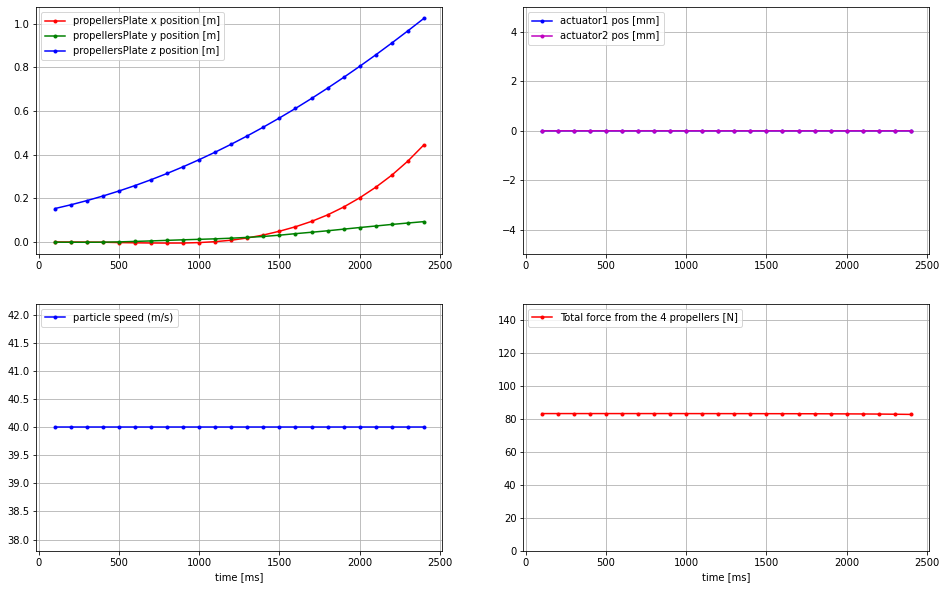

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))

#M : [timeSimu, pos1, pos2, propPlate_x, propPlate_y, propPlate_z, particle_speed, total_force]
    
plt.subplot(221)
plt.plot(M[:,0],M[:,3],'.-r', label='propellersPlate x position [m]')
plt.plot(M[:,0],M[:,4],'.-g', label='propellersPlate y position [m]')
plt.plot(M[:,0],M[:,5],'.-b', label='propellersPlate z position [m]')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(222)
plt.plot(M[:,0],M[:,1]*1e3,'.-b', label='actuator1 pos [mm]')
plt.plot(M[:,0],M[:,2]*1e3,'.-m', label='actuator2 pos [mm]')
plt.legend(loc='upper left')
plt.ylim(-5,5)
plt.grid()

plt.subplot(223)
plt.plot(M[:,0],M[:,6],'.-b', label='particle speed (m/s)')
plt.xlabel('time [ms]')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(224)
plt.plot(M[:,0],M[:,7],'.-r', label='Total force from the 4 propellers [N]')
plt.xlabel('time [ms]')
plt.legend(loc='upper left')
plt.ylim(0,150)
plt.grid()


## simxCloseScene

In [ ]:
res = sim.simxCloseScene(clientID, opmode_blocking)

 ## Close the simulator

 **Only for Linux & MacOS** !!! <br>
=> Windows : close the CoppeliaSim window 'by hand'...

In [ ]:
if platform.system() =='Linux':
    simulator.end()
elif platform.system() =='Darwin':
    import os
    os.system("pkill coppeliaSim")
else:
    print("Windows : close the CoppeliaSim window 'by hand'...")